In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# # !pip install tensorflow
# !pip install category_encoders
# !pip install dacon_submit_api-0.0.4-py3-none-any.whl
# !pip install mljar-supervised

In [1]:
# from pycaret.time_series import *

import pandas as pd
from pandas import Series, DataFrame
import numpy as np
import category_encoders as ce

# Visualization
import matplotlib.pylab as plt
from matplotlib import font_manager, rc
import matplotlib
import seaborn as sns
# import plotly.express as px
%matplotlib inline
matplotlib.rcParams['font.family'] = 'Malgun Gothic' # 한글 패치
# Preprocessing & Feature Engineering
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.feature_selection import SelectPercentile
from sklearn.model_selection import KFold

# Hyperparameter Optimization
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# Modeling
# from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.neural_network import MLPClassifier
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.ensemble import ExtraTreesClassifier
# from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier, XGBRegressor, XGBRFRegressor
from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier, VotingRegressor
from sklearn.ensemble import StackingClassifier, StackingRegressor
# from sklearn.base import ClassifierMixin

# CatBoost
# from catboost import CatBoostRegressor

# PyTorch
# import torch
# from torch.utils.data import Dataset, DataLoader, TensorDataset
# import torch.nn as nn
# import torch.nn.functional as F
# import torch.optim as optim
# from torch.autograd import Variable
# from torch.nn import Parameter
# from torch import Tensor
# from torch.utils.data import DataLoader

# # for Torch hyper parameter tuning
# from functools import partial
# from torch.utils.data import random_split
# import torchvision
# import torchvision.transforms as transforms
# from ray import tune
# from ray.tune import CLIReporter
# from ray.tune.schedulers import ASHAScheduler

# Evaluation
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import log_loss,mean_squared_error

# Utility
import os
import time
import datetime # ⚠️2019년 12월30일과 31일의 week of year가 1인 오류가 있음
import random
import warnings; warnings.filterwarnings("ignore")
from IPython.display import Image
import pickle
from tqdm import tqdm
import platform
from itertools import combinations
from scipy.stats.mstats import gmean
import holidays

# from bayes_opt import BayesianOptimization
# from num2words import num2words
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import OLSInfluence

pd.set_option('display.max_columns', None)

In [2]:
import os
import random

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42) # Seed 고정

path = '../data/daegu/'
# path = './drive/MyDrive/Colab Notebooks/data/daegu/'
train_df = pd.read_csv(path+'train.csv')
test_df = pd.read_csv(path+'test.csv')

# display(train.head())
# display(test.head())

In [3]:
import numpy as np
from supervised import AutoML

In [4]:
train_df['사고일시'] = pd.to_datetime(train_df['사고일시'])

In [5]:
test_df['사고일시'] = pd.to_datetime(test_df['사고일시'])

# 군과 구를 나눠줍니다

In [6]:
train_df['군'] = ''
train_df['구'] = ''

test_df['군'] = ''
test_df['구'] = ''

# 주소 분리 및 군과 구 열에 저장
for i in range(0, len(train_df)):
    address = train_df['시군구'][i]
    elements = address.split(" ")
    if len(elements) == 3:
        city = elements[0]
        county = elements[1]
        district = elements[2]
        train_df.at[i, '군'] = county
        train_df.at[i, '구'] = district
    else:
        print(f"잘못된 주소 형식입니다: {address}")

# 결과 출력
display(train_df.head(5))

,ID,사고일시,요일,기상상태,시군구,도로형태,노면상태,사고유형,사고유형 - 세부분류,법규위반,가해운전자 차종,가해운전자 성별,가해운전자 연령,가해운전자 상해정도,피해운전자 차종,피해운전자 성별,피해운전자 연령,피해운전자 상해정도,사망자수,중상자수,경상자수,부상자수,ECLO,군,구
0,ACCIDENT_00000,2019-01-01 00:00:00,화요일,맑음,대구광역시 중구 대신동,단일로 - 기타,건조,차대사람,길가장자리구역통행중,안전운전불이행,승용,여,51세,상해없음,보행자,여,70세,중상,0,1,0,0,5,중구,대신동
1,ACCIDENT_00001,2019-01-01 00:00:00,화요일,흐림,대구광역시 달서구 감삼동,단일로 - 기타,건조,차대사람,보도통행중,기타,승용,남,39세,상해없음,보행자,남,61세,경상,0,0,1,0,3,달서구,감삼동
2,ACCIDENT_00002,2019-01-01 01:00:00,화요일,맑음,대구광역시 수성구 두산동,단일로 - 기타,건조,차대사람,차도통행중,안전운전불이행,승용,남,70세,상해없음,보행자,남,38세,경상,0,0,1,0,3,수성구,두산동
3,ACCIDENT_00003,2019-01-01 02:00:00,화요일,맑음,대구광역시 북구 복현동,단일로 - 기타,건조,차대차,추돌,안전운전불이행,승용,남,49세,상해없음,승용,남,36세,중상,0,1,0,0,5,북구,복현동
4,ACCIDENT_00004,2019-01-01 04:00:00,화요일,맑음,대구광역시 동구 신암동,단일로 - 기타,건조,차대차,추돌,안전운전불이행,승용,남,30세,상해없음,승용,남,52세,경상,0,0,1,0,3,동구,신암동


In [7]:
for i in range(0, len(test_df)):
    address = test_df['시군구'][i]
    elements = address.split(" ")
    if len(elements) == 3:
        city = elements[0]
        county = elements[1]
        district = elements[2]
        test_df.at[i, '군'] = county
        test_df.at[i, '구'] = district
    else:
        print(f"잘못된 주소 형식입니다: {address}")

# 결과 출력
display(test_df.head(5))

,ID,사고일시,요일,기상상태,시군구,도로형태,노면상태,사고유형,군,구
0,ACCIDENT_39609,2022-01-01 01:00:00,토요일,맑음,대구광역시 수성구 상동,교차로 - 교차로안,건조,차대사람,수성구,상동
1,ACCIDENT_39610,2022-01-01 01:00:00,토요일,맑음,대구광역시 수성구 지산동,단일로 - 기타,건조,차대사람,수성구,지산동
2,ACCIDENT_39611,2022-01-01 04:00:00,토요일,맑음,대구광역시 수성구 수성동2가,교차로 - 교차로안,건조,차대차,수성구,수성동2가
3,ACCIDENT_39612,2022-01-01 04:00:00,토요일,맑음,대구광역시 수성구 신매동,단일로 - 기타,건조,차대차,수성구,신매동
4,ACCIDENT_39613,2022-01-01 06:00:00,토요일,맑음,대구광역시 달서구 감삼동,교차로 - 교차로안,건조,차대차,달서구,감삼동


# 외부 데이터 사용

이 부분은 이희원님의 코드를 참고하였습니다.

In [8]:
light_df = pd.read_csv(path+'external_open/대구 보안등 정보.csv', encoding='cp949')[['설치개수', '소재지지번주소']]

location_pattern = r'(\S+) (\S+) (\S+) (\S+)'

light_df[['도시', '군', '구', '번지']] = light_df['소재지지번주소'].str.extract(location_pattern)
light_df = light_df.drop(columns=['소재지지번주소', '번지'])

light_df = light_df.groupby(['도시', '군', '구']).sum().reset_index()
light_df.reset_index(inplace=True, drop=True)

In [9]:
parking_df = pd.read_csv(path+'external_open/대구 주차장 정보.csv', encoding='cp949')[['소재지지번주소', '급지구분']]
parking_df = pd.get_dummies(parking_df, columns=['급지구분'])

location_pattern = r'(\S+) (\S+) (\S+) (\S+)'

parking_df[['도시', '군', '구', '번지']] = parking_df['소재지지번주소'].str.extract(location_pattern)
parking_df = parking_df.drop(columns=['소재지지번주소', '번지'])

parking_df = parking_df.groupby(['도시', '군', '구']).sum().reset_index()
parking_df.reset_index(inplace=True, drop=True)

In [10]:
child_area_df = pd.read_csv(path+'external_open/대구 어린이 보호 구역 정보.csv', encoding='cp949').drop_duplicates()[['소재지지번주소']]
child_area_df['cnt'] = 1

location_pattern = r'(\S+) (\S+) (\S+) (\S+)'

child_area_df[['도시', '군', '구', '번지']] = child_area_df['소재지지번주소'].str.extract(location_pattern)
child_area_df = child_area_df.drop(columns=['소재지지번주소', '번지'])

child_area_df = child_area_df.groupby(['도시', '군', '구']).sum().reset_index()
child_area_df.reset_index(inplace=True, drop=True)

In [11]:
train_df = pd.merge(train_df, light_df, how='left', on=['군', '구'])
train_df = pd.merge(train_df, child_area_df, how='left', on=['군', '구'])
train_df = pd.merge(train_df, parking_df, how='left', on=['군', '구'])

test_df = pd.merge(test_df, light_df, how='left', on=['군', '구'])
test_df = pd.merge(test_df, child_area_df, how='left', on=['군', '구'])
test_df = pd.merge(test_df, parking_df, how='left', on=['군', '구'])

In [12]:
test_df['군'].unique()

array(['수성구', '달서구', '중구', '동구', '서구', '북구', '남구', '달성군'], dtype=object)

In [15]:
멈춰

NameError: name '멈춰' is not defined

## One-hot-encoding

In [13]:
from sklearn.preprocessing import OneHotEncoder

# train_df와 test_df의 기상상태 및 노면상태 열 선택
train_categorical_data = train_df[['군']]
test_categorical_data = test_df[['군']]

# OneHotEncoder 인스턴스 생성 및 fit_transform 수행
encoder = OneHotEncoder()
train_encoded = encoder.fit_transform(train_categorical_data)
test_encoded = encoder.transform(test_categorical_data)

# OneHotEncoder가 사용한 카테고리 목록을 가져와서 카테고리 이름을 열 이름으로 변환
feature_names = encoder.get_feature_names_out(['군'])

# 밀집 행렬로 변환 (선택 사항)
train_encoded_dense = train_encoded.toarray()
test_encoded_dense = test_encoded.toarray()

# 데이터프레임으로 변환 (선택 사항)
import pandas as pd

train_encoded_df = pd.DataFrame(train_encoded_dense, columns=feature_names, index=train_df.index)
test_encoded_df = pd.DataFrame(test_encoded_dense, columns=feature_names, index=test_df.index)

# 기존 열 제거
train_df = train_df.drop(['군', ], axis=1)
test_df = test_df.drop(['군'], axis=1)

# 인코딩된 열 추가
train_df = pd.concat([train_df, train_encoded_df], axis=1)
test_df = pd.concat([test_df, test_encoded_df], axis=1)


In [14]:
train_df

,ID,사고일시,요일,기상상태,시군구,도로형태,노면상태,사고유형,사고유형 - 세부분류,법규위반,가해운전자 차종,가해운전자 성별,가해운전자 연령,가해운전자 상해정도,피해운전자 차종,피해운전자 성별,피해운전자 연령,피해운전자 상해정도,사망자수,중상자수,경상자수,부상자수,ECLO,구,도시_x,설치개수,도시_y,cnt,도시,급지구분_1,급지구분_2,급지구분_3,군_남구,군_달서구,군_달성군,군_동구,군_북구,군_서구,군_수성구,군_중구
0,ACCIDENT_00000,2019-01-01 00:00:00,화요일,맑음,대구광역시 중구 대신동,단일로 - 기타,건조,차대사람,길가장자리구역통행중,안전운전불이행,승용,여,51세,상해없음,보행자,여,70세,중상,0,1,0,0,5,대신동,대구광역시,391.0,대구광역시,2.0,대구광역시,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,ACCIDENT_00001,2019-01-01 00:00:00,화요일,흐림,대구광역시 달서구 감삼동,단일로 - 기타,건조,차대사람,보도통행중,기타,승용,남,39세,상해없음,보행자,남,61세,경상,0,0,1,0,3,감삼동,대구광역시,932.0,NaN,NaN,대구광역시,0.0,1.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ACCIDENT_00002,2019-01-01 01:00:00,화요일,맑음,대구광역시 수성구 두산동,단일로 - 기타,건조,차대사람,차도통행중,안전운전불이행,승용,남,70세,상해없음,보행자,남,38세,경상,0,0,1,0,3,두산동,대구광역시,473.0,대구광역시,5.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,ACCIDENT_00003,2019-01-01 02:00:00,화요일,맑음,대구광역시 북구 복현동,단일로 - 기타,건조,차대차,추돌,안전운전불이행,승용,남,49세,상해없음,승용,남,36세,중상,0,1,0,0,5,복현동,대구광역시,534.0,대구광역시,11.0,대구광역시,0.0,9.0,5.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,ACCIDENT_00004,2019-01-01 04:00:00,화요일,맑음,대구광역시 동구 신암동,단일로 - 기타,건조,차대차,추돌,안전운전불이행,승용,남,30세,상해없음,승용,남,52세,경상,0,0,1,0,3,신암동,대구광역시,2057.0,NaN,NaN,대구광역시,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39604,ACCIDENT_39604,2021-12-31 19:00:00,금요일,맑음,대구광역시 수성구 수성동3가,교차로 - 교차로안,건조,차대차,측면충돌,신호위반,승용,여,52세,상해없음,이륜,남,28세,경상,0,0,1,0,3,수성동3가,NaN,NaN,대구광역시,1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
39605,ACCIDENT_39605,2021-12-31 19:00:00,금요일,맑음,대구광역시 달서구 상인동,단일로 - 기타,건조,차대차,측면충돌,안전거리미확보,승용,여,60세,상해없음,승용,남,52세,경상,0,0,1,0,3,상인동,대구광역시,843.0,NaN,NaN,대구광역시,0.0,0.0,5.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
39606,ACCIDENT_39606,2021-12-31 21:00:00,금요일,맑음,대구광역시 달서구 월성동,교차로 - 교차로안,건조,차대차,측면충돌,교차로운행방법위반,승용,남,60세,중상,승용,남,73세,중상,0,2,0,0,10,월성동,대구광역시,164.0,NaN,NaN,대구광역시,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
39607,ACCIDENT_39607,2021-12-31 22:00:00,금요일,맑음,대구광역시 달서구 장동,기타 - 기타,건조,차대차,추돌,안전운전불이행,승용,남,40세,상해없음,승용,여,57세,경상,0,0,1,0,3,장동,대구광역시,210.0,NaN,NaN,대구광역시,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


# 시군구별 발생횟수 feature 추가

In [15]:
accident_counts = train_df['시군구'].value_counts().reset_index()
accident_counts.columns = ['시군구', '사고횟수']

In [16]:
# '시군구'별 사고 횟수를 train_df에 매핑하기 위해 '시군구' 컬럼을 기준으로 사고 횟수를 가져옵니다.
train_df['사고발생횟수'] = train_df['시군구'].map(accident_counts.set_index('시군구')['사고횟수'])


In [17]:
# '시군구'별 사고 횟수를 train_df에 매핑하기 위해 '시군구' 컬럼을 기준으로 사고 횟수를 가져옵니다.
test_df['사고발생횟수'] = test_df['시군구'].map(accident_counts.set_index('시군구')['사고횟수'])


In [18]:
train_df

,ID,사고일시,요일,기상상태,시군구,도로형태,노면상태,사고유형,사고유형 - 세부분류,법규위반,가해운전자 차종,가해운전자 성별,가해운전자 연령,가해운전자 상해정도,피해운전자 차종,피해운전자 성별,피해운전자 연령,피해운전자 상해정도,사망자수,중상자수,경상자수,부상자수,ECLO,구,도시_x,설치개수,도시_y,cnt,도시,급지구분_1,급지구분_2,급지구분_3,군_남구,군_달서구,군_달성군,군_동구,군_북구,군_서구,군_수성구,군_중구,사고발생횟수
0,ACCIDENT_00000,2019-01-01 00:00:00,화요일,맑음,대구광역시 중구 대신동,단일로 - 기타,건조,차대사람,길가장자리구역통행중,안전운전불이행,승용,여,51세,상해없음,보행자,여,70세,중상,0,1,0,0,5,대신동,대구광역시,391.0,대구광역시,2.0,대구광역시,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,131
1,ACCIDENT_00001,2019-01-01 00:00:00,화요일,흐림,대구광역시 달서구 감삼동,단일로 - 기타,건조,차대사람,보도통행중,기타,승용,남,39세,상해없음,보행자,남,61세,경상,0,0,1,0,3,감삼동,대구광역시,932.0,NaN,NaN,대구광역시,0.0,1.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,678
2,ACCIDENT_00002,2019-01-01 01:00:00,화요일,맑음,대구광역시 수성구 두산동,단일로 - 기타,건조,차대사람,차도통행중,안전운전불이행,승용,남,70세,상해없음,보행자,남,38세,경상,0,0,1,0,3,두산동,대구광역시,473.0,대구광역시,5.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,604
3,ACCIDENT_00003,2019-01-01 02:00:00,화요일,맑음,대구광역시 북구 복현동,단일로 - 기타,건조,차대차,추돌,안전운전불이행,승용,남,49세,상해없음,승용,남,36세,중상,0,1,0,0,5,복현동,대구광역시,534.0,대구광역시,11.0,대구광역시,0.0,9.0,5.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,426
4,ACCIDENT_00004,2019-01-01 04:00:00,화요일,맑음,대구광역시 동구 신암동,단일로 - 기타,건조,차대차,추돌,안전운전불이행,승용,남,30세,상해없음,승용,남,52세,경상,0,0,1,0,3,신암동,대구광역시,2057.0,NaN,NaN,대구광역시,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,825
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39604,ACCIDENT_39604,2021-12-31 19:00:00,금요일,맑음,대구광역시 수성구 수성동3가,교차로 - 교차로안,건조,차대차,측면충돌,신호위반,승용,여,52세,상해없음,이륜,남,28세,경상,0,0,1,0,3,수성동3가,NaN,NaN,대구광역시,1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,104
39605,ACCIDENT_39605,2021-12-31 19:00:00,금요일,맑음,대구광역시 달서구 상인동,단일로 - 기타,건조,차대차,측면충돌,안전거리미확보,승용,여,60세,상해없음,승용,남,52세,경상,0,0,1,0,3,상인동,대구광역시,843.0,NaN,NaN,대구광역시,0.0,0.0,5.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1143
39606,ACCIDENT_39606,2021-12-31 21:00:00,금요일,맑음,대구광역시 달서구 월성동,교차로 - 교차로안,건조,차대차,측면충돌,교차로운행방법위반,승용,남,60세,중상,승용,남,73세,중상,0,2,0,0,10,월성동,대구광역시,164.0,NaN,NaN,대구광역시,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,618
39607,ACCIDENT_39607,2021-12-31 22:00:00,금요일,맑음,대구광역시 달서구 장동,기타 - 기타,건조,차대차,추돌,안전운전불이행,승용,남,40세,상해없음,승용,여,57세,경상,0,0,1,0,3,장동,대구광역시,210.0,NaN,NaN,대구광역시,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,125


In [ ]:
test_df

In [19]:
# datetime 컬럼 처리
train_df['사고일시'] = pd.to_datetime(train_df['사고일시'])
test_df['사고일시'] = pd.to_datetime(test_df['사고일시'])

# datetime을 여러 파생 변수로 변환
for df in [train_df, test_df]:
    df['year'] = df['사고일시'].dt.year
    df['month'] = df['사고일시'].dt.month
    df['day'] = df['사고일시'].dt.day
    df['hour'] = df['사고일시'].dt.hour
    df['minute'] = df['사고일시'].dt.minute
    df['weekday'] = df['사고일시'].dt.weekday

In [20]:
holi_weekday = ['2019-01-01', '2019-02-04', '2019-02-05', '2019-02-06', '2019-03-01', '2019-05-05', '2019-05-12', '2019-06-06', '2019-08-15', '2019-09-12', '2019-09-13', '2019-09-14', '2019-10-03', '2019-10-09', '2019-12-25',
                '2020-01-01' ,'2020-01-24' ,'2020-01-25', '2020-01-26', '2020-03-01', '2020-04-30', '2020-05-05', '2020-06-06', '2020-08-15', '2020-08-17', '2020-09-30', '2020-10-01', '2020-10-02', '2020-10-03', '2020-10-09', '2020-12-25',
                '2021-01-01' ,'2021-02-11' ,'2021-02-12', '2021-02-13', '2021-03-01', '2021-05-05', '2021-05-19', '2021-06-06', '2021-08-15', '2021-09-20', '2021-09-21', '2021-09-22', '2021-10-03', '2021-10-09', '2021-12-25',
                '2022-01-01' ,'2022-01-31' ,'2022-02-01', '2022-02-02', '2022-03-01', '2022-05-05', '2022-05-08', '2022-06-06', '2022-08-15', '2022-09-09', '2022-09-10', '2022-09-11', '2022-09-12', '2022-10-03', '2022-10-09', '2020-10-10', '2022-12-25',
                '2023-01-01' ,'2023-01-21' ,'2023-01-22', '2023-01-23', '2023-01-24', '2023-03-01']

In [21]:
train_df['사고일시'] = pd.to_datetime(train_df['사고일시'])
train_df['day_of_week'] = train_df['사고일시'].dt.dayofweek
train_df['holiday'] = np.where((train_df.day_of_week >= 5) | (train_df.사고일시.dt.strftime('%Y-%m-%d').isin(holi_weekday)), 1, 0)

In [22]:
test_df['사고일시'] = pd.to_datetime(test_df['사고일시'])
test_df['day_of_week'] = test_df['사고일시'].dt.dayofweek
test_df['holiday'] = np.where((test_df.day_of_week >= 5) | (test_df.사고일시.dt.strftime('%Y-%m-%d').isin(holi_weekday)), 1, 0)

In [23]:
train_df = train_df.drop(columns=['사고유형 - 세부분류','법규위반','가해운전자 차종','가해운전자 성별','가해운전자 연령',
                               '가해운전자 상해정도','사망자수','사망자수','중상자수','피해운전자 차종','피해운전자 성별',
                      '피해운전자 연령','피해운전자 상해정도','경상자수','부상자수','사고유형 - 세부분류'])

# 계절 변수 추가

In [24]:
def group_season(df):
    df.loc[(df['month'] == 3) | (df['month'] == 4) | (df['month'] == 5), 'season'] = '봄'
    df.loc[(df['month'] == 6) | (df['month'] == 7) | (df['month'] == 8), 'season'] = '여름'
    df.loc[(df['month'] == 9) | (df['month'] == 10) | (df['month'] == 11), 'season'] = '가을'
    df.loc[(df['month'] == 12) | (df['month'] == 1) | (df['month'] == 2), 'season'] = '겨울'
    return df['season']

train_df['Cosine_Time'] = np.cos(2 * np.pi * train_df['hour'] / 24)
test_df['Cosine_Time'] = np.cos(2 * np.pi * test_df['hour'] / 24)
train_df['season'] = group_season(train_df)
test_df['season'] = group_season(test_df)

(239,)


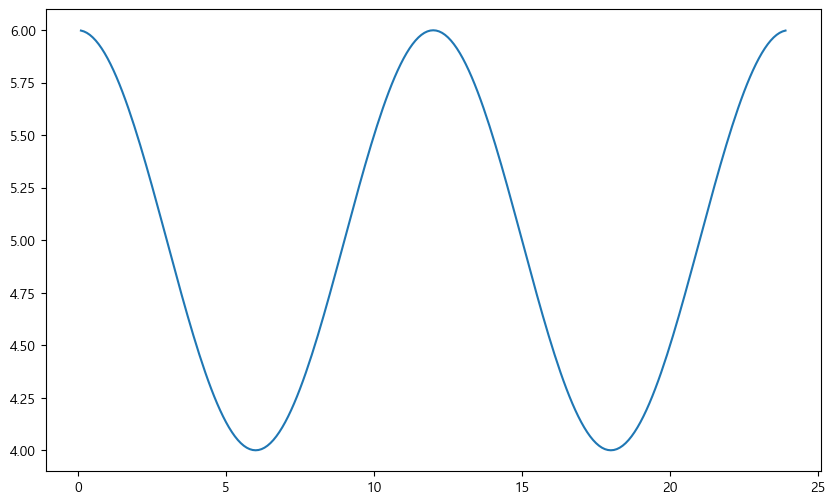

In [5]:
x = np.arange(0.1,24, 0.1)
# y = np.array(x) * 5
cos_y = np.sign(np.pi*x/6) + np.cos(np.pi*x/6) +4 
# cos_y = np.sign(np.pi*2*x/24) + np.cos(np.pi*2*x/24) + np.sign(np.pi*4*x/24) + np.cos(np.pi*4*x/24)

print(cos_y.shape)

fig,axs = plt.subplots(figsize=(10,6))
sns.lineplot(x=x,y=cos_y, ax=axs)
plt.show()

(239,)


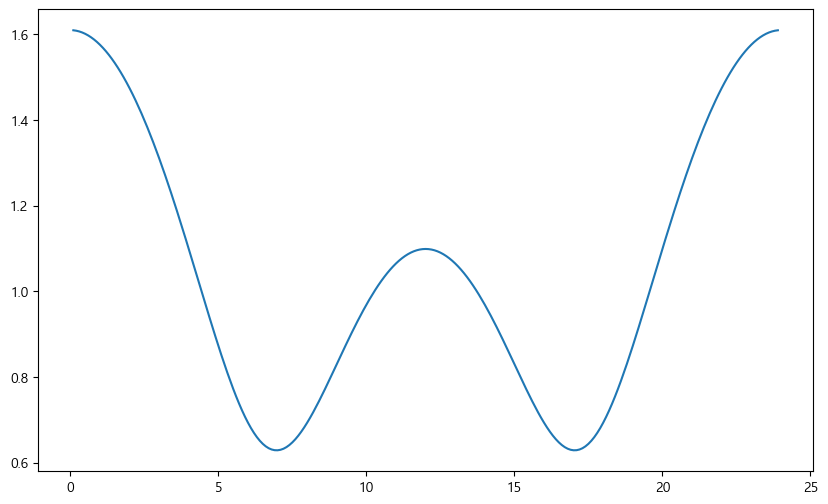

In [4]:
x = np.arange(0.1,24, 0.1)
cos_y = np.sign(np.pi*2*x/24) + np.cos(np.pi*2*x/24) + np.sign(np.pi*4*x/24) + np.cos(np.pi*4*x/24)
print(cos_y.shape)

fig,axs = plt.subplots(figsize=(10,6))
sns.lineplot(x=x,y=np.log1p(cos_y), ax=axs)
plt.show()

(119,)


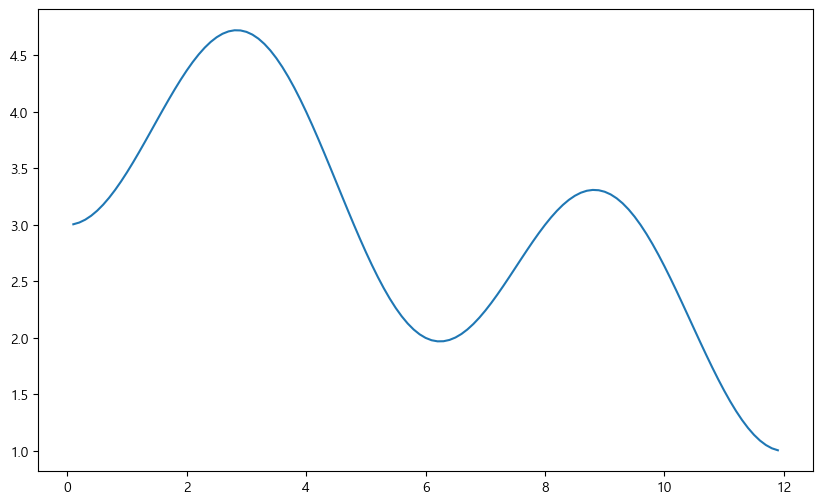

In [157]:
x = np.arange(0.1,12, 0.1)
cos_y = -np.cos(np.pi*2*x/12) + np.cos(np.pi*2*x/12) - np.cos(np.pi*4*x/12) + np.sign(np.pi*5*x/12) + np.cos(np.pi*1*x/12) 
cos_y = cos_y+2
print(cos_y.shape)

fig,axs = plt.subplots(figsize=(10,6))
sns.lineplot(x=x,y=cos_y, ax=axs)
plt.show()

# Target-Encoding

In [25]:
# Target encoding
from category_encoders.target_encoder import TargetEncoder

categorical_features = ['ID','시군구','요일','도로형태','사고유형','구','기상상태', '노면상태','season']

for i in categorical_features:
    tr_encoder = TargetEncoder(cols=[i])
    train_df[i] = tr_encoder.fit_transform(train_df[i], train_df['ECLO'])
    test_df[i] = tr_encoder.transform(test_df[i])

In [26]:
target = train_df['ECLO']

In [27]:
train_df['ECLO'] = target

In [ ]:
# train_df.corr()

In [28]:
train_df = train_df.drop(columns=['ECLO'])

In [29]:
test_df = test_df.drop(columns=['사고일시'])

In [ ]:
train_df.columns

In [30]:
train_df

,ID,사고일시,요일,기상상태,시군구,도로형태,노면상태,사고유형,구,도시_x,설치개수,도시_y,cnt,도시,급지구분_1,급지구분_2,급지구분_3,군_남구,군_달서구,군_달성군,군_동구,군_북구,군_서구,군_수성구,군_중구,사고발생횟수,year,month,day,hour,minute,weekday,day_of_week,holiday,Cosine_Time,season
0,4.762262,2019-01-01 00:00:00,4.627926,4.712888,4.282449,4.653990,4.712878,3.817650,4.282449,대구광역시,391.0,대구광역시,2.0,대구광역시,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,131,2019,1,1,0,0,1,1,1,1.000000,4.659111
1,4.502045,2019-01-01 00:00:00,4.627926,4.779150,4.738938,4.653990,4.712878,3.817650,4.738938,대구광역시,932.0,NaN,NaN,대구광역시,0.0,1.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,678,2019,1,1,0,0,1,1,1,1.000000,4.659111
2,4.502045,2019-01-01 01:00:00,4.627926,4.712888,4.842715,4.653990,4.712878,3.817650,4.842715,대구광역시,473.0,대구광역시,5.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,604,2019,1,1,1,0,1,1,1,0.965926,4.659111
3,4.762262,2019-01-01 02:00:00,4.627926,4.712888,4.208920,4.653990,4.712878,4.944597,4.208920,대구광역시,534.0,대구광역시,11.0,대구광역시,0.0,9.0,5.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,426,2019,1,1,2,0,1,1,1,0.866025,4.659111
4,4.502045,2019-01-01 04:00:00,4.627926,4.712888,4.549091,4.653990,4.712878,4.944597,4.549091,대구광역시,2057.0,NaN,NaN,대구광역시,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,825,2019,1,1,4,0,1,1,1,0.500000,4.659111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39604,4.502045,2021-12-31 19:00:00,4.600906,4.712888,4.913420,5.006142,4.712878,4.944597,4.913420,NaN,NaN,대구광역시,1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,104,2021,12,31,19,0,4,4,0,0.258819,4.659111
39605,4.502045,2021-12-31 19:00:00,4.600906,4.712888,4.293963,4.653990,4.712878,4.944597,4.293963,대구광역시,843.0,NaN,NaN,대구광역시,0.0,0.0,5.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1143,2021,12,31,19,0,4,4,0,0.258819,4.659111
39606,5.412804,2021-12-31 21:00:00,4.600906,4.712888,4.648867,5.006142,4.712878,4.944597,4.648867,대구광역시,164.0,NaN,NaN,대구광역시,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,618,2021,12,31,21,0,4,4,0,0.707107,4.659111
39607,4.502045,2021-12-31 22:00:00,4.600906,4.712888,4.672002,4.065962,4.712878,4.944597,4.672002,대구광역시,210.0,NaN,NaN,대구광역시,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,125,2021,12,31,22,0,4,4,0,0.866025,4.659111


## 비비드백님의 인사이트를 참고하였습니다

In [ ]:
test_x = test_df.drop(columns=['ID','도시_x','도시_y','도시','year','month','day','hour','minute','day_of_week','사고일시']).copy()
train_x = train_df[test_x.columns].copy()
train_y = train_df['ECLO'].copy()

In [ ]:
test_x.columns

In [ ]:
test_x

In [ ]:
train_x['cnt'] = train_x['cnt'].interpolate()
train_x['설치개수'] = train_x['설치개수'].interpolate()
train_x['급지구분_1'] = train_x['급지구분_1'].interpolate()
train_x['급지구분_2'] = train_x['급지구분_2'].interpolate()
train_x['급지구분_3'] = train_x['급지구분_3'].interpolate()

# ⚠️ 엄밀히 따지면 test 데이터셋에느 interpolate을 하면 안 될 것 같기두...
test_x['cnt'] = test_x['cnt'].interpolate()
test_x['설치개수'] = test_x['설치개수'].interpolate()
test_x['급지구분_1'] = test_x['급지구분_1'].interpolate()
test_x['급지구분_2'] = test_x['급지구분_2'].interpolate()
test_x['급지구분_3'] = test_x['급지구분_3'].interpolate()

test_x['급지구분_1'] = test_x['급지구분_1'].fillna(0)
test_x['급지구분_2'] = test_x['급지구분_2'].fillna(0)
test_x['급지구분_3'] = test_x['급지구분_3'].fillna(0)

In [ ]:
print(train_x.isnull().sum())
print(test_x.isnull().sum())

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(train_x, train_y, test_size=0.2, random_state=42)

### AUTOML

In [ ]:
import matplotlib
matplotlib.use('Agg')

In [ ]:
from supervised.automl import AutoML
automl = AutoML(mode="Compete",
                algorithms = ['Random Forest', 'LightGBM', 'Xgboost', 'CatBoost'],
                n_jobs = -1,total_time_limit=43200, eval_metric="rmse", ml_task = "regression",)
#3.209155

In [ ]:
automl.fit(train_x, train_y)

In [ ]:
pred = automl.predict(test_x)

## 제출

In [ ]:
submission = pd.read_csv(path+'sample_submission.csv')

In [ ]:
submission['ECLO'] = pred

In [ ]:
submission.loc[ submission['ECLO'] < 0.0, 'ECLO'] = 0.0

In [ ]:
min(submission['ECLO'])

In [ ]:
submission

In [ ]:
# submission.to_csv('submit.csv', index=False)

submit_path = "../data/submits/automl_1206_001.csv"
submission.to_csv(submit_path, index=False)

In [ ]:
멈춰ㅏ!

In [ ]:
from dacon_submit_api import dacon_submit_api

result = dacon_submit_api.post_submission_file(
  submit_path,
  '99e503e9d7311db9f4167d982d5823d7ef9427cc628aa63b96cf79d2920ba916',
  '236193',
  'song999',
  '12.06 - 001. automl' )